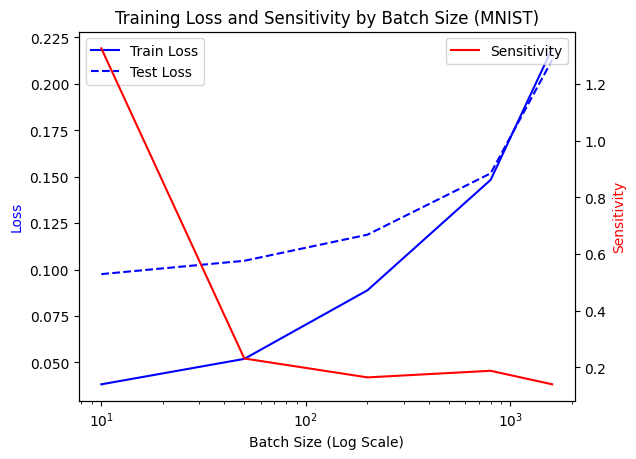

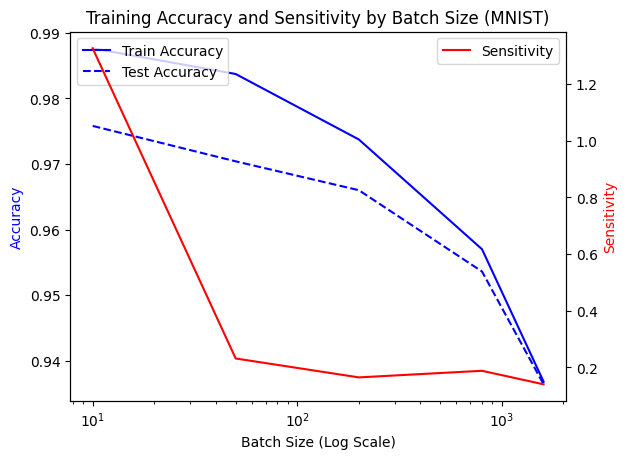

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading MNIST dataset with transformations
transform_data = transforms.ToTensor()
train_set = datasets.MNIST(root='C:\\Users\\lokes\\OneDrive\\Desktop\\deep', train=True, download=True, transform=transform_data)
test_set = datasets.MNIST(root='C:\\Users\\lokes\\OneDrive\\Desktop\\deep', train=False, download=True, transform=transform_data)

# batch sizes
batch_sizes_var = [10, 50, 200, 800, 1600]

# Preparing data loaders for each batch size
train_data_loaders = [DataLoader(train_set, batch_size=batch, shuffle=True) for batch in batch_sizes_var]
test_data_loaders = [DataLoader(test_set, batch_size=batch, shuffle=True) for batch in batch_sizes_var]

# Function to calculate the number of parameters in a neural network model
def calculate_parameters(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

# neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden1=64, hidden2=32, hidden3=16, output_size=10):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, hidden3)  # Adding an additional hidden layer
        self.output_layer = nn.Linear(hidden3, output_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.output_layer(x)
        return x

# Function to handle training and testing of the model
def train_test_nn(model, train_loader, test_loader, loss_fn, optimizer_fn, epochs=10):
    train_losses, test_losses = [], []
    train_accuracy, test_accuracy = [], []

    for epoch in range(epochs):
        model.train()  # Training mode
        running_train_loss = 0
        correct_train_preds = 0

        # Training loop
        for inputs_train, labels_train in train_loader:
            optimizer_fn.zero_grad()
            predictions_train = model(inputs_train.view(inputs_train.size(0), -1))
            loss = loss_fn(predictions_train, labels_train)
            loss.backward()
            optimizer_fn.step()

            running_train_loss += loss.item()
            predicted_labels = torch.max(predictions_train.data, 1)[1]
            correct_train_preds += (predicted_labels == labels_train).sum().item()

        # Append average loss and accuracy for this epoch
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracy.append(correct_train_preds / len(train_loader.dataset))

        model.eval()  # Evaluation mode
        running_test_loss = 0
        correct_test_preds = 0
        with torch.no_grad():
            for inputs_test, labels_test in test_loader:
                predictions_test = model(inputs_test.view(inputs_test.size(0), -1))
                loss = loss_fn(predictions_test, labels_test)
                running_test_loss += loss.item()
                predicted_labels = torch.max(predictions_test.data, 1)[1]
                correct_test_preds += (predicted_labels == labels_test).sum().item()

        # Append average test loss and accuracy for this epoch
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracy.append(correct_test_preds / len(test_loader.dataset))

    return train_losses, test_losses, train_accuracy, test_accuracy

# Training the models with various batch sizes and collecting results
nn_models = [SimpleNN() for _ in batch_sizes_var]
training_losses, testing_losses, training_accuracies, testing_accuracies = [], [], [], []
model_sensitivity = []

for i, (nn_model, train_loader, test_loader) in enumerate(zip(nn_models, train_data_loaders, test_data_loaders)):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

    train_loss, test_loss, train_acc, test_acc = train_test_nn(nn_model, train_loader, test_loader, criterion, optimizer)
    training_losses.append(train_loss[-1])  # Final epoch loss
    testing_losses.append(test_loss[-1])    # Final epoch loss
    training_accuracies.append(train_acc[-1])  # Final epoch accuracy
    testing_accuracies.append(test_acc[-1])    # Final epoch accuracy

    # Sensitivity: Frobenius norm of gradients
    grad_norm_total = 0
    num_params = 0
    for param in nn_model.parameters():
        if param.grad is not None:
            grad_norm = torch.linalg.norm(param.grad).item()
            grad_norm_total += grad_norm
            num_params += 1
    model_sensitivity.append(grad_norm_total / num_params)

# Plotting Loss vs Sensitivity
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(batch_sizes_var, training_losses, 'b-', label='Train Loss')
ax1.plot(batch_sizes_var, testing_losses, 'b--', label='Test Loss')
ax2.plot(batch_sizes_var, model_sensitivity, 'r-', label='Sensitivity')
ax1.set_xlabel('Batch Size (Log Scale)')
ax1.set_xscale('log')
ax1.set_ylabel('Loss', color='b')
ax2.set_ylabel('Sensitivity', color='r')
plt.title('Training Loss and Sensitivity by Batch Size (MNIST)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# Plotting Accuracy vs Sensitivity
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(batch_sizes_var, training_accuracies, 'b-', label='Train Accuracy')
ax1.plot(batch_sizes_var, testing_accuracies, 'b--', label='Test Accuracy')
ax2.plot(batch_sizes_var, model_sensitivity, 'r-', label='Sensitivity')
ax1.set_xlabel('Batch Size (Log Scale)')
ax1.set_xscale('log')
ax1.set_ylabel('Accuracy', color='b')
ax2.set_ylabel('Sensitivity', color='r')
plt.title('Training Accuracy and Sensitivity by Batch Size (MNIST)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()
